In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from Dnn_utils import  sigmoid, sigmoid_backward, relu, relu_backward
from shallowData import load_dataset
%matplotlib inline

In [2]:
train_set_x_orig, test_set_x_orig,train_set_y,test_set_y, classes = load_dataset()

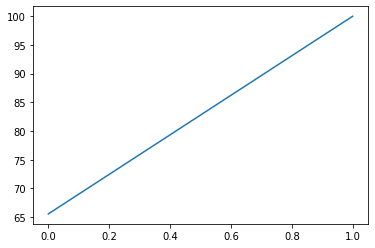

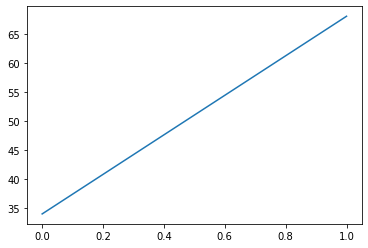

Train accuracy100.0%
Test accuracy72.0%


In [11]:
train_set_x_flat=train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
train_set_x=train_set_x_flat/255

test_set_x_flat=test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_set_x=test_set_x_flat/255

def layer_sizes(X,Y):
    n_x=X.shape[0]
    n_y=Y.shape[0]
    return n_x,n_y
def initialize_parameters(layer_dims):
    parameters={}
    for i in range(1,len(layer_dims)):
        parameters["W"+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/layer_dims[i-1])
        parameters["b"+str(i)]=np.zeros((layer_dims[i],1))
    return parameters
def random_mini_batches(X,Y,mini_batch_sizes=64):
    m=X.shape[1]
    mini_batches=[]
    permutation=list(np.random.permutation(m))
    shuffled_X=X[:,permutation]
    shuffled_Y=Y[:,permutation].reshape((1,m))
    num_complete_minibatches=math.floor(m/mini_batch_sizes)
    for k in range(num_complete_minibatches):
        mini_batch_X=shuffled_X[:,k*mini_batch_sizes:(k+1)*mini_batch_sizes]
        mini_batch_Y=shuffled_Y[:,k*mini_batch_sizes:(k+1)*mini_batch_sizes]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    if (m%mini_batch_sizes!=0):
        mini_batch_X=shuffled_X[:,num_complete_minibatches*mini_batch_sizes:m]
        mini_batch_Y=shuffled_Y[:,num_complete_minibatches*mini_batch_sizes:m]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches
def initialize_adam(parameters):  #initailize v and s to a zero matrix
    L=len(parameters)//2
    v={}
    s={}
    for l in range(L):
        v["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
        v["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
        s["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0],parameters["W"+str(l+1)].shape[1]))
        s["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
    return v,s
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1=0.9,beta2=0.999,epsilon=1e-8):
    L=len(parameters)//2
    v_corrected={}
    s_corrected={}
    for l in range(L):
        v["dW"+str(l+1)]=(beta1*v["dW"+str(l+1)])+((1-beta1)*grads["dW"+str(l+1)])
        v["db"+str(l+1)]=(beta1*v["db"+str(l+1)])+((1-beta1)*grads["db"+str(l+1)])
        s["dW"+str(l+1)]=(beta2*s["dW"+str(l+1)])+((1-beta2)*pow(grads["db"+str(l+1)],2))
        s["db"+str(l+1)]=(beta2*s["db"+str(l+1)])+((1-beta2)*pow(grads["db"+str(l+1)],2))
        # bias correction
        v_corrected["dW"+str(l+1)]=v["dW"+str(l+1)]/(1-pow(beta1,t))
        v_corrected["db"+str(l+1)]=v["db"+str(l+1)]/(1-pow(beta1,t))
        s_corrected["dW"+str(l+1)]=s["dW"+str(l+1)]/(1-pow(beta2,t))
        s_corrected["db"+str(l+1)]=s["db"+str(l+1)]/(1-pow(beta2,t))
        # update parameters
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-learning_rate*(v_corrected["dW"+str(l+1)]/(pow(s_corrected["dW"+str(l+1)]+epsilon,0.5)))
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-learning_rate*(v_corrected["db"+str(l+1)]/(pow(s_corrected["db"+str(l+1)]+epsilon,0.5)))
    return parameters,v,s

def linear_forward(W,A,b):
    Z=np.dot(W,A)+b
    cache=(W,A,b)
    return Z,cache
def linear_activation_forward(W,A_prev,b,activation):
    if(activation=="relu"):
        Z,linear_cache=linear_forward(W,A_prev,b)
        A,activation_cache=relu(Z)
    elif(activation=="sigmoid"):
        Z,linear_cache=linear_forward(W,A_prev,b)
        A,activation_cache = sigmoid(Z)
    cache=(linear_cache,activation_cache)
    return A,cache
def L_model_forward(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for i in range(1,L):
        A,cache=linear_activation_forward(parameters["W"+str(i)],A,parameters["b"+str(i)],"relu")
        caches.append(cache)
    A,cache=linear_activation_forward(parameters["W"+str(L)],A,parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    AL=A
    return AL,caches
def linear_backward(dZ,cache):
    W,A_prev,b=cache
    m=A_prev.shape[1]
    dW=np.dot(dZ,A_prev.T)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dW,dA_prev,db
def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache=cache
    if(activation=="relu"):
        dZ=relu_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward(dZ,linear_cache)
    elif(activation=="sigmoid"):
        dZ=sigmoid_backward(dA,activation_cache)
        dW,dA_prev,db=linear_backward(dZ,linear_cache)
    return dW,dA_prev,db
def L_model_backward(AL,Y,caches):#caches is(linear_cache,activation_cache)
    L=len(caches)
    m=AL.shape[1]
    grads={}
    current_cache=caches[L-1]
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    grads["dW"+str(L)],grads["dA"+str(L-1)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,"sigmoid")
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
    return grads
# not used here(general gradient descent)
def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for i in range(1,L+1):
          parameters["W"+str(i)]=parameters["W"+str(i)]-learning_rate*grads["dW"+str(i)]
          parameters["b"+str(i)]=parameters["b"+str(i)]-learning_rate*grads["db"+str(i)]
    return parameters
def predict(parameters,X):
    AL,caches=L_model_forward(X,parameters)
    Y_prediction=np.round(AL)
    return Y_prediction
  
def train_model(X_train,Y_train,layer_dims,num_iterations,learning_rate):
    parameters=initialize_parameters(layer_dims)
    train=[]
    test=[]
    v,s=initialize_adam(parameters)
    for i in range(num_iterations):
        t=1
        minibatches=random_mini_batches(X_train,Y_train,mini_batch_sizes=32)# minibatches=[(mini-batch_x{1},mini_batch_y{1}),.....]
        for minibatch in minibatches:
            mini_X,mini_Y=minibatch
            AL,caches=L_model_forward(mini_X,parameters)
            grads=L_model_backward(AL,mini_Y,caches)
            parameters,v,s=update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1=0.9,beta2=0.999,epsilon=1e-8)
            t=t+1
        if(i%2000==0):
            Y_train_prediction=predict(parameters,train_set_x)
            train.append(100-np.mean(np.abs(Y_train_prediction-train_set_y))*100)
            Y_test_prediction=predict(parameters,test_set_x)
            test.append(100-np.mean(np.abs(Y_test_prediction-test_set_y))*100)
    plt.plot(train)
    plt.show()
    plt.plot(test)
    plt.show()
    return parameters
n_x,n_y=layer_sizes(train_set_x,train_set_y)
d=train_model(train_set_x,train_set_y,[n_x,20,7,5,n_y],3000,0.0007)
Y_train_prediction=predict(d,train_set_x)
Y_test_prediction=predict(d,test_set_x)
print("Train accuracy{}%".format(100-np.mean(np.abs(Y_train_prediction-train_set_y))*100))
print("Test accuracy{}%".format(100-np.mean(np.abs(Y_test_prediction-test_set_y))*100))


          
        
        
        
    